In [1]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


# models
#from keras.applications.vgg16 import VGG16
#from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import tensorflow as tf
import PIL as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from random import randint
import pandas as pd
import pickle

In [2]:
!pwd

/Users/thorsten/code/ThorstenCodes/MorphoMind/Notebooks


In [3]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Base directory
base_dir = '/Users/thorsten/code/ThorstenCodes/MorphoMind/raw_data'
plate = '24277'  # Convert plate number to string for path operations
channels = ['Hoechst', 'Ph_golgi','ERSytoBleed', 'ERSyto', 'Mito'] # 'Ph_golgi','ERSytoBleed', 'ERSyto',  'Mito'

# Initialize a list to hold all preprocessed images
images = []

# Loop through each channel and process images
for channel in channels:
    # Construct channel directory path correctly
    channel_dir = os.path.join(base_dir, f"plate_{plate}/{plate}-{channel}/")

    # Check if the channel directory exists
    if os.path.isdir(channel_dir):
        # List all TIFF image files in the directory
        image_files = [os.path.join(channel_dir, f) for f in os.listdir(channel_dir) if f.lower().endswith('tif')]

        # Load and preprocess the images
        for img_path in image_files:
            img = load_img(img_path, target_size=(224, 224))
            img = img_to_array(img)
            images.append(img)
    else:
        print(f"Directory {channel_dir} not found.")

# Convert list of images to a numpy array
images = np.array(images)

# Now `images` contains all preprocessed images ready for analysis
print(f"Loaded {len(images)} images.")

Loaded 11520 images.


In [4]:
images.shape

(11520, 224, 224, 3)

In [5]:
images

array([[[[152., 152., 152.],
         [145., 145., 145.],
         [143., 143., 143.],
         ...,
         [165., 165., 165.],
         [169., 169., 169.],
         [157., 157., 157.]],

        [[152., 152., 152.],
         [151., 151., 151.],
         [145., 145., 145.],
         ...,
         [158., 158., 158.],
         [166., 166., 166.],
         [159., 159., 159.]],

        [[140., 140., 140.],
         [146., 146., 146.],
         [141., 141., 141.],
         ...,
         [156., 156., 156.],
         [151., 151., 151.],
         [154., 154., 154.]],

        ...,

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
       

In [6]:
import tensorflow as tf
from tensorflow import keras

def build_feature_extractor(img_width=224, img_height=224, pretrained_model='MobileNetV2'):
    # Correctly initialize models and preprocessing functions
    models = {'MobileNetV2': tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, pooling="avg", input_shape=(img_height, img_width, 3))}
    #preprocess = {'MobileNetV2': keras.applications.mobilenet_v2.preprocess_input}

    feature_extractor = models[pretrained_model]
    #preprocess_input = preprocess[pretrained_model]

    inputs = keras.Input((img_height, img_width, 3))
    preprocessed = preprocess_input(inputs)
    outputs = feature_extractor(preprocessed)

    return keras.Model(inputs, outputs, name="feature_extractor")

In [7]:
print(tf.__version__)

2.15.0


In [8]:
# Initialize the feature extractor model
feature_extractor_model = build_feature_extractor()

In [9]:
# Extract features
features = feature_extractor_model.predict(images)

360/360 [==============================] - 78s 214ms/step


In [10]:
# Number of clusters
n_clusters = 5

# Initialize KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit KMeans on the features
kmeans.fit(features)

# Get cluster labels for each image
cluster_labels = kmeans.labels_

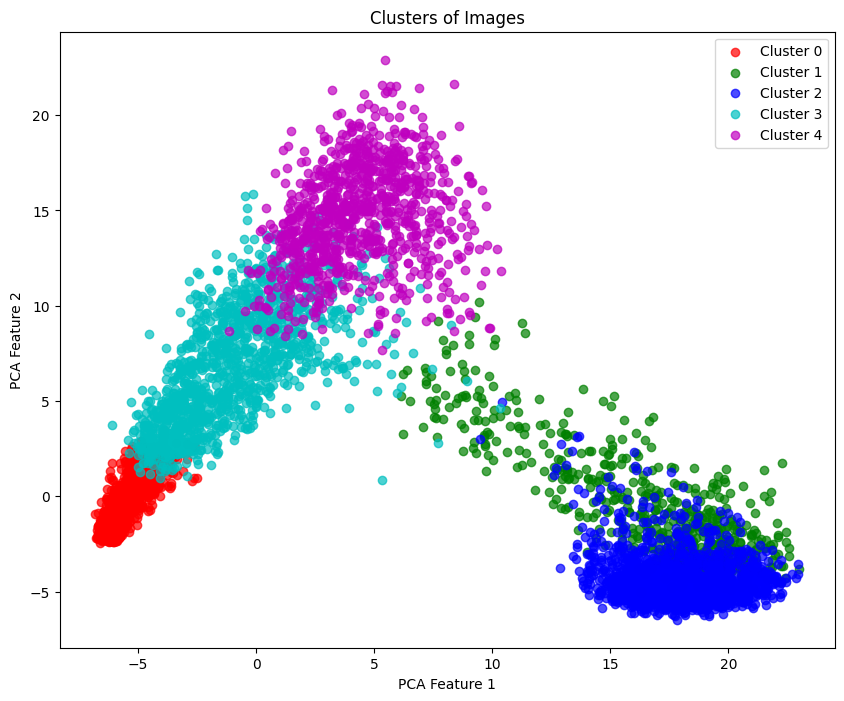

In [11]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming `features` is your dataset and KMeans has already been fitted as shown in your snippet.

# Number of components for PCA
n_components = 2

# Initialize and fit PCA
pca = PCA(n_components=n_components)
reduced_features = pca.fit_transform(features)

# Use the cluster labels from your KMeans model
cluster_labels = kmeans.labels_

# Plotting
plt.figure(figsize=(10, 8))

# Color map for clusters
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for i in range(n_clusters):
    plt.scatter(reduced_features[cluster_labels == i, 0], reduced_features[cluster_labels == i, 1], label=f'Cluster {i}', alpha=0.7, color=colors[i % len(colors)])

plt.title('Clusters of Images')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `images` is your array of images and `cluster_labels` are your KMeans cluster labels
n_clusters = 5  # The number of clusters you have
images_per_cluster = 1

# Normalize your int64 images by dividing by 256 as per your request
normalized_images = images.astype('float64') / 256.0

# Plotting
fig, axs = plt.subplots(n_clusters, images_per_cluster, figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust space between plots

for i in range(n_clusters):
    cluster_indices = np.where(cluster_labels == i)[0]
    selected_indices = cluster_indices[:images_per_cluster]  # Select up to 5 images from this cluster

    for j, idx in enumerate(selected_indices):
        if n_clusters > 1:
            ax = axs[i, j]
        else:  # If only one cluster, axs is a 1D array
            ax = axs[j]
        ax.imshow(normalized_images[idx], cmap='viridis')  # Use 'viridis' colormap
        ax.axis('off')
        if j == 0:  # Label only the first image of each cluster for clarity
            ax.set_title(f'Cluster {i+1}', fontsize=20, color='black')

plt.show()  # Make sure to display the plot


: 

In [ ]:
# Assuming `images` is a list of paths to your images
batch_size = 32  # Adjust based on your memory capacity

# Load the model outside of your loop to avoid redundant initializations
feature_extractor_model = build_feature_extractor()

# Prepare a list to hold feature vectors
features = []

for i in range(0, len(images), batch_size):
    batch_images = images[i:i+batch_size]
    batch_arrays = []

    # Load and preprocess images in the current batch
    for image_path in batch_images:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Model expects a batch dimension
        batch_arrays.append(img_array)

    batch_arrays = np.vstack(batch_arrays)  # Stack images into a single numpy array
    batch_arrays = keras.applications.mobilenet_v2.preprocess_input(batch_arrays)  # Preprocess the whole batch

    # Use the feature extractor model
    batch_features = feature_extractor_model.predict(batch_arrays)
    features.extend(batch_features)

# Now, `features` contains the extracted features for all your images